In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPool1D, Dropout, Flatten, Dense
from sklearn.metrics import classification_report


In [2]:
df = pd.read_csv('dataset/card_transdata.csv')

In [3]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


# Descrição da Váriaveis

| Coluna                        | Descrição                                                               |
|-------------------------------|-------------------------------------------------------------------------|
|distance from home	            | Distância da casa onde a transação aconteceu                            |
|distance from last transaction	| Distância da última transação                                           |
|ratio to median purchase_price	| Relação entre a transação do preço de compra e o preço de compra médio  |
|repeat retailer	            | Se a transação ocorreu na mesma loja (1 - sim 0 - não)                  |
|used_chip	                    | A transação através de chip (Compra física) (1 - sim 0 - não)           |
|used pin number	            | A transação ocorreu usando o número PIN (1 - sim 0 - não)               |
|online_order	                | Transação online (1 - sim  0 - não)                                     |
|fraud                          | Transação fraudulenta (1 - sim  0 - não)                                |

# Análise Exploratoria. 

In [4]:
print(f"Colunas: {df.shape[1]}\nLinhas: {df.shape[0]}")

Colunas: 8
Linhas: 1000000


In [5]:
# Verificando os tipos dos dados 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [6]:
# Verificando dados faltantes 

df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [7]:
# Verificando dados duplicados

df.duplicated().sum()

0

In [8]:
# Estatistica Básica. 

df.describe().T

,count,mean,std,min,25%,50%,75%,max
distance_from_home,1000000.0,26.628792,65.390784,0.004874,3.878008,9.967760,25.743985,10632.723672
distance_from_last_transaction,1000000.0,5.036519,25.843093,0.000118,0.296671,0.998650,3.355748,11851.104565
ratio_to_median_purchase_price,1000000.0,1.824182,2.799589,0.004399,0.475673,0.997717,2.096370,267.802942
repeat_retailer,1000000.0,0.881536,0.323157,0.000000,1.000000,1.000000,1.000000,1.000000
used_chip,1000000.0,0.350399,0.477095,0.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,1000000.0,0.100608,0.300809,0.000000,0.000000,0.000000,0.000000,1.000000
online_order,1000000.0,0.650552,0.476796,0.000000,0.000000,1.000000,1.000000,1.000000
fraud,1000000.0,0.087403,0.282425,0.000000,0.000000,0.000000,0.000000,1.000000


In [9]:
frauds = pd.DataFrame(df['fraud'].value_counts()).reset_index()
frauds

,fraud,count
0,0.0,912597
1,1.0,87403


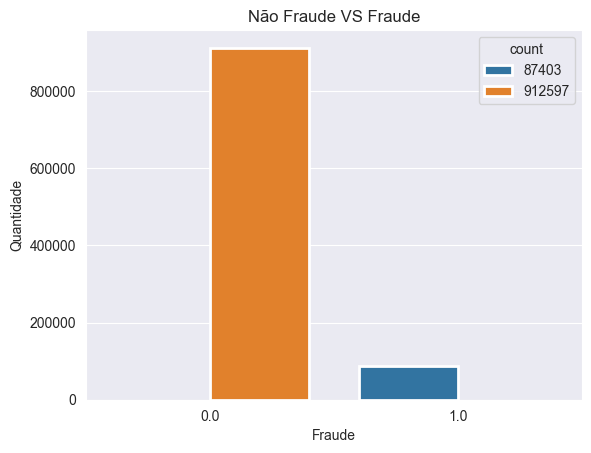

In [10]:
# Fraude vs não fraude

sns.set_style("darkgrid")
ax = sns.barplot(x='fraud', y='count', data=frauds, linewidth=2, hue='count')
plt.xlabel('Fraude')
plt.ylabel('Quantidade')
plt.title('Não Fraude VS Fraude');

Como é comom nesses de dedeção de fraudes a grande maioria das transações será na classe “Não Fraude”.

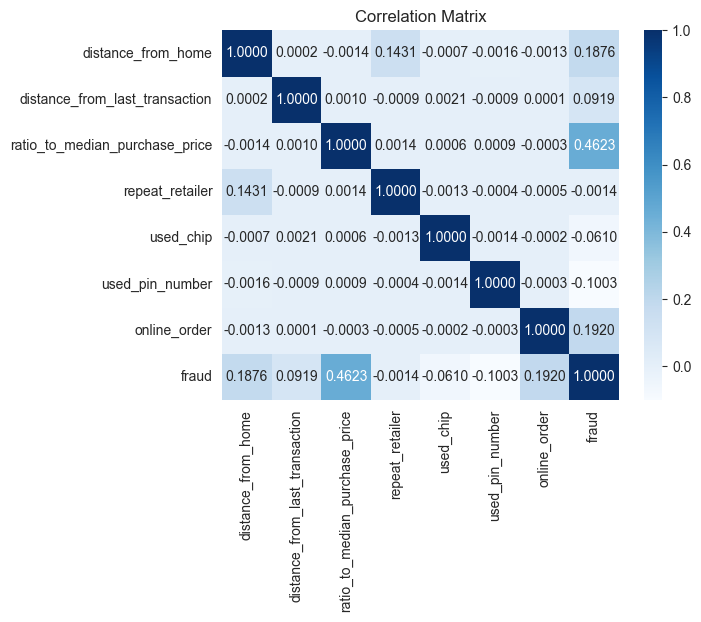

In [11]:
sns.heatmap(df.corr(), annot=True, fmt='.4f', cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

A maioria dos valores de correlação está próxima ou abaixo de 0, o que indica que nossos recursos estão fracamente correlacionados.

É aqui que os Autoencoders se mostram úteis, pois podem capturar relacionamentos complexos nos dados.

# Histograma dos dados

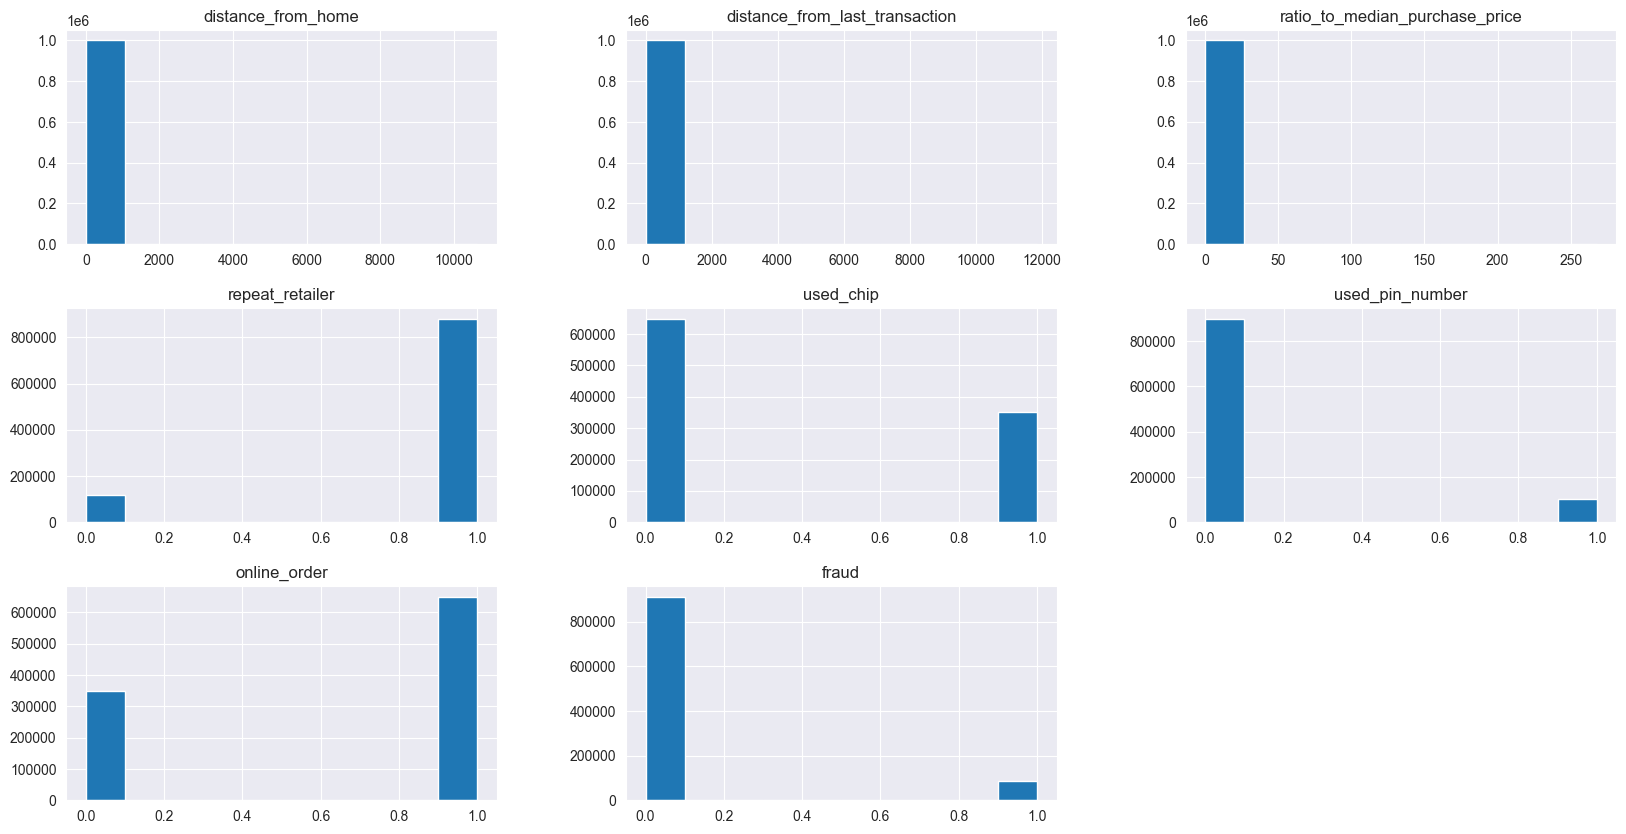

In [12]:
distribuicao_dados = df.hist(figsize=(20, 10))

# Pré-Processamento

In [13]:
# Obtendo nosso X e Y

x = df.drop(['fraud'], axis=1)
y = df['fraud']

In [14]:
# Seperando treino e teste

x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.20, # 20% será usando para teste
    random_state=40)

In [15]:
# Normalização do Dados.

scaler  = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [16]:
# Como vamos usar o CNN precisamos converter as arrays para arrays tridimensionais

# x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
# x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

# Treinamento

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [23]:
# Criando a Rede - Build CNN (Convolutional Neural Network)


model = Sequential([
    Dense(units=16, kernel_initializer='uniform', input_dim=30, activation='relu'),
    Dense(units=18, kernel_initializer='uniform', activation='relu'),
    Dropout(0.25),
    Dense(20, kernel_initializer='uniform', activation='relu'),
    Dense(24, kernel_initializer='uniform', activation='relu'),
    Dense(1, kernel_initializer='uniform', activation='sigmoid')
])

In [24]:
# Sumario da rede neural

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                496       
                                                                 
 dense_6 (Dense)             (None, 18)                306       
                                                                 
 dropout_1 (Dropout)         (None, 18)                0         
                                                                 
 dense_7 (Dense)             (None, 20)                380       
                                                                 
 dense_8 (Dense)             (None, 24)                504       
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1711 (6.68 KB)
Trainable params: 1711 (6

In [29]:
model = Sequential([
    Dense(units=16, kernel_initializer='uniform', input_dim=7, activation='relu'),
    Dense(units=18, kernel_initializer='uniform', activation='relu'),
    Dropout(0.25),
    Dense(20, kernel_initializer='uniform', activation='relu'),
    Dense(24, kernel_initializer='uniform', activation='relu'),
    Dense(1, kernel_initializer='uniform', activation='sigmoid')
])

# Paranmetro 

num_epoch = 50
batch_size = 128
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compilando o modelo

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Treine o modelo com os seus dados

model.fit(x_train, y_train, epochs=num_epoch, batch_size=batch_size, validation_data=(x_test, y_test))

Epoch 1/50
6250/6250 [==============================] - 25s 4ms/step - loss: 0.5927 - accuracy: 0.9125 - val_loss: 0.3595 - val_accuracy: 0.9127
Epoch 2/50
6250/6250 [==============================] - 23s 4ms/step - loss: 0.2198 - accuracy: 0.9126 - val_loss: 0.1571 - val_accuracy: 0.9127
Epoch 3/50
6250/6250 [==============================] - 21s 3ms/step - loss: 0.1319 - accuracy: 0.9126 - val_loss: 0.1024 - val_accuracy: 0.9543
Epoch 4/50
6250/6250 [==============================] - 21s 3ms/step - loss: 0.0969 - accuracy: 0.9633 - val_loss: 0.0877 - val_accuracy: 0.9722
Epoch 5/50
6250/6250 [==============================] - 23s 4ms/step - loss: 0.0861 - accuracy: 0.9726 - val_loss: 0.0800 - val_accuracy: 0.9744
Epoch 6/50
6250/6250 [==============================] - 23s 4ms/step - loss: 0.0788 - accuracy: 0.9748 - val_loss: 0.0735 - val_accuracy: 0.9761
Epoch 7/50
6250/6250 [==============================] - 21s 3ms/step - loss: 0.0723 - accuracy: 0.9766 - val_loss: 0.0677 - val_ac

In [ ]:
# Predições 

y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

6250/6250 [==============================] - 15s 2ms/step


In [ ]:
# Matriz Confusão

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[181258   1280]
 [    78  17384]]


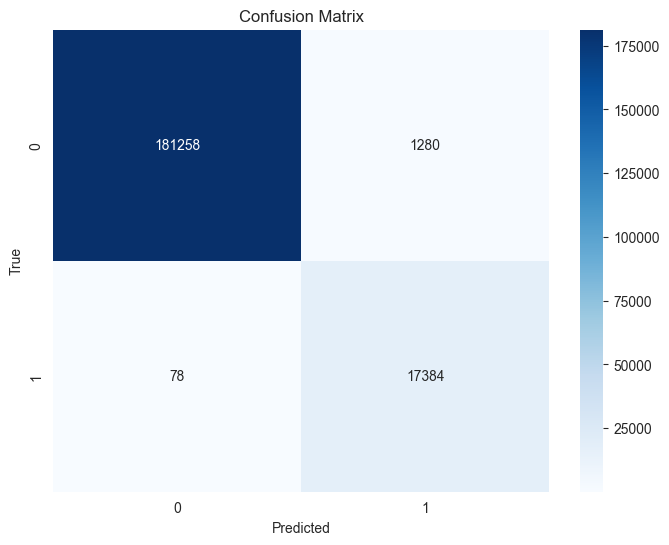

In [ ]:
# Plot Matriz Confução 

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Accuracy Score

acc_cm = accuracy_score(y_test, y_pred)
print("Accuracy:", acc_cm)

Accuracy: 0.99321


In [ ]:
# Calcular a precisão

precisao = accuracy_score(y_test, y_pred)

print(f'A precisão do modelo é: {precisao:.2f}')

A precisão do modelo é: 0.99


In [ ]:
# Calcular o recall

recall = recall_score(y_test, y_pred)

print(f'O recall do modelo é: {recall:.2f}')

O recall do modelo é: 1.00


In [ ]:
# Classification Report

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    182538
         1.0       0.93      1.00      0.96     17462

    accuracy                           0.99    200000
   macro avg       0.97      0.99      0.98    200000
weighted avg       0.99      0.99      0.99    200000



In [ ]:
import pickle

# Salvar o modelo em um arquivo
with open('modelo.pkl', 'wb') as arquivo:
    pickle.dump(model, arquivo)


In [ ]:
# Carregar o modelo

with open('modelo.pkl', 'rb') as arquivo:
    modelo = pickle.load(arquivo)
